# How to predict stock market using Google Tensorflow and LSTM neural network

https://medium.com/@dmytrosazonov/how-to-predict-stock-market-using-google-tensorflow-and-lstm-neural-network-81ccc41a22a8


## Tools and libraries
During our experiment we will be using:

- Python
- Google Collaboration (Colab)
- Google Tensorflow and Keras
- panda
- numpy
- sklearn
- yahoo_fin
- matplotlib.pyplot

## Imports
First of all, let’s start from the imports. We need to import the following list of libraries which we will be using during the experiment.

In [ ]:
%pwd
%ls

In [ ]:
%pip install -r requirements.txt

In [2]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

2023-11-22 15:32:24.224406: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-22 15:32:24.224490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-22 15:32:24.379929: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-22 15:32:24.685076: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 15:32:27.314608: W tensorflow/comp

## Settings
For our neural network we will use some settings. Here’s the short explanation of each of them:

- Parameter ‘N_STEPS’ means the number of days for our window. It is the depth which our neural network will be using;
- Parameter ‘LOOKUP_STEPS’ is the array which includes the number and sequence of days which we will predict for. There are three days in our example [1 day — the next day, tomorrow, 2 — second day, the day after tomorrow, 3 — third day, the day after the second day]. If we want to predict for 4 or 5 days, — we need to put in here the following numbers like this [1, 2, 3, 4, 5]
- Parameter ‘STOCK’ corresponds to ticker on the market which we will investigate in our study. For instance, in our case it is Google (GOOGL the ticker on NASDAQ);
- As you may see we also use ‘date_now’ which is the current day and ‘date_3_years_back’ which will let us look 1104 days back in the retrospective history of the daily price for the abovementioned stock ticker;

In [3]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL
STOCK = 'MSFT'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

## Load data

In order to work with data we need to load it from Yahoo Finance.

In [4]:
# LOAD DATA 
# from yahoo_fin 
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK, 
    start_date=date_3_years_back, 
    end_date=date_now, 
    interval='1d')

print(init_df.tail())
init_df.head()

                  open        high         low       close    adjclose  \
2023-11-15  371.279999  373.130005  367.109985  369.670013  369.670013   
2023-11-16  370.959991  376.350006  370.179993  376.170013  376.170013   
2023-11-17  373.609985  374.369995  367.000000  369.850006  369.850006   
2023-11-20  371.220001  378.869995  371.000000  377.440002  377.440002   
2023-11-21  375.670013  376.220001  371.119995  373.070007  373.070007   

              volume ticker  
2023-11-15  26860100   MSFT  
2023-11-16  27182300   MSFT  
2023-11-17  40157000   MSFT  
2023-11-20  52465100   MSFT  
2023-11-21  28343200   MSFT  


,open,high,low,close,adjclose,volume,ticker
2020-11-13,216.360001,217.419998,214.160004,216.509995,210.296921,18621100,MSFT
2020-11-16,214.869995,217.740005,214.520004,217.229996,210.996246,24953300,MSFT
2020-11-17,216.100006,217.679993,214.080002,214.460007,208.305740,24154100,MSFT
2020-11-18,213.649994,215.169998,210.929993,211.080002,205.559494,28372800,MSFT
2020-11-19,211.380005,213.029999,209.929993,212.419998,206.864410,24792700,MSFT


But we do not need to put all these columns into the machine learning model. We just need one column ‘close’ which is the price on the closing market on the particular day.

In [5]:
# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index
init_df.tail()

,close,date
2023-11-15,369.670013,2023-11-15
2023-11-16,376.170013,2023-11-16
2023-11-17,369.850006,2023-11-17
2023-11-20,377.440002,2023-11-20
2023-11-21,373.070007,2023-11-21


While we are here and have genuine data that we retrieved from the service, let’s make a plot to show the graphic.

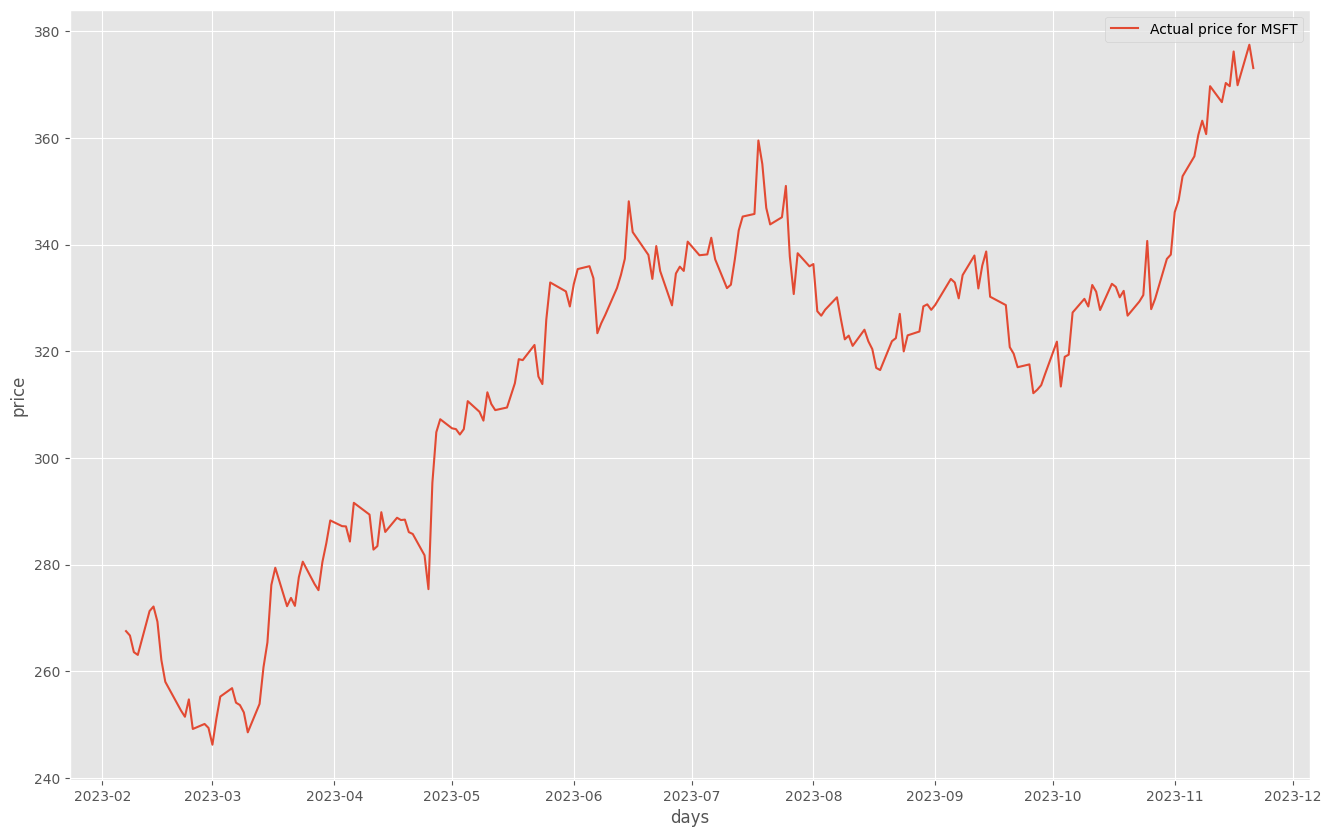

In [6]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}'])
plt.show()

### Scale data

As we use LSTM neural network we need to scale the data in the column ‘Close’ because the machine learning algorithm works much better with scaled than with regular data. Therefore, we need the following code:



In [7]:
# Scale data for ML engine
scaler = MinMaxScaler()
init_df['close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))
init_df.tail()

,close,date
2023-11-15,0.953565,2023-11-15
2023-11-16,0.992410,2023-11-16
2023-11-17,0.954641,2023-11-17
2023-11-20,1.000000,2023-11-20
2023-11-21,0.973884,2023-11-21


## Prepare data for the engine

So, we have data, preliminary loaded and scaled for the machine learning model. However, we need to prepare it for the next procedure. And here’s why.

Our initial goal is to predict the stock price for the upcoming three days. It means that we have to shift bars on number of days we want to predict it for and prepare the data for the model accordingly.

In our case, the column ‘close’ is the target column and we will shift it and save the results in the column ‘future’. This is our shift itself.



In [8]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['close'].shift(-days)
  last_sequence = np.array(df[['close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

Also, in this script we need to calculate the last sequence which has the last window for the engine. We will predict prices for future days using that sequence.

Final things are the arrays of X’s and Y’s for the LSTM. X’s is the array of sequence on the particular step. The Y’s is array of target price on the particular step. I highly recommend you to experiment with all of these parts in Google Colab to fully understand what is going on.

## Machine learning model

So, it’s time for machine learning model and its settings. As you’ve probably guessed, we use LSTM neural network and sequential model in this approach. We have a few LSTM and Dropout layers, as well as Dense layer which is final one.

Parameter ‘x_train’ is the array of data, prepared for the model to train this;

Parameter ‘y_train’ is the target column ‘close’ which we use to give the answer on our training;

60 neurons on the first layer of LSTM, 120 neurons on the second layer of LSTM. Between the LSTM layers there are hidden layers with dropped by 30% (0.3) neurons. And finally we have Dense with 20 neurons as well as just one neuron which is our result on the last step of the model.

In [9]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

We are gonna teach our model during 80 epochs (computations) with batch size on each epoch equal to 8.

We use ‘mean_squared_error’ as a parameter for loss function and optimizer ‘adam’ which is the most popular in tasks of stock price prediction.

Finally we will summarize the results of model teaching and return the model to the main program to let it use the model for the stock market prediction.

Definitely, it is not the comprehensive description of what is going on in here. However, I didn’t aim for it. In order to fully understand it you will need to spend at least 6 hours watching an appropriate course on Pluralsight.

## Predict stock prices

Now we have everything we need to start predicting the GOOGL prices for the upcoming 3 days.

In the following script we initialize the array of predicted prices. Then, in the loop we prepare the data and train the model on each step (for each day from our array of days [1, 2, 3]). You probably remember our setting chapter where we set to LOOKUP_STEPS the value = [1, 2, 3]. Three days: first, second and the third one.



In [10]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80
95/95 [==============================] - 6s 18ms/step - loss: 0.0117
Epoch 2/80
95/95 [==============================] - 2s 19ms/step - loss: 0.0045
Epoch 3/80
95/95 [==============================] - 2s 17ms/step - loss: 0.0039
Epoch 4/80
95/95 [==============================] - 2s 20ms/step - loss: 0.0043
Epoch 5/80
95/95 [==============================] - 2s 19ms/step - loss: 0.0035
Epoch 6/80
95/95 [==============================] - 2s 20ms/step - loss: 0.0035
Epoch 7/80
95/95 [==============================] - 2s 19ms/step - loss: 0.0031
Epoch 8/80
95/95 [==============================] - 1s 16ms/step - loss: 0.0029
Epoch 9/80
95/95 [==============================] - 1s 12ms/step - loss: 0.0025
Epoch 10/80
95/95 [==============================] - 1s 11ms/step - loss: 0.0028
Epoch 11/80
95/95 [==============================] - 1s 14ms/step - loss: 0.0027
Epoch 12/80
95/95 [==============================] - 1s 14ms/step - loss: 0.0027
Epoch 13/80
95/95 [==================

In [11]:
if bool(predictions) == True and len(predictions) > 0:
    predictions_list = [str(d)+'$' for d in predictions]
    predictions_str = ', '.join(predictions_list)
    message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'
    print(message)

MSFT prediction for upcoming 3 days (382.69$, 380.27$, 365.51$)


Nuevo desafio: https://medium.com/@dmytrosazonov/trading-algorithm-that-doesnt-work-37e747f4c6a6